In [ ]:
# Draft code for making a 1D contrast curve for my Altair data, for R>lambda/D

# Created 2019 Nov. 25 by E.S.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

%matplotlib qt

In [36]:
def radial_data(data,annulus_width=1,working_mask=None,x=None,y=None,rmax=None):
    """
    From https://people.ucsc.edu/~ianc/python/_modules/radial_data.html
    
    r = radial_data(data,annulus_width,working_mask,x,y)
    
    A function to reduce an image to a radial cross-section.
    
    :INPUT:
      data   - whatever data you are radially averaging.  Data is
              binned into a series of annuli of width 'annulus_width'
              pixels.

      annulus_width - width of each annulus.  Default is 1.

      working_mask - array of same size as 'data', with zeros at
                        whichever 'data' points you don't want included
                        in the radial data computations.

      x,y - coordinate system in which the data exists (used to set
               the center of the data).  By default, these are set to
               integer meshgrids

      rmax -- maximum radial value over which to compute statistics
    
    :OUTPUT:
        r - a data structure containing the following
                   statistics, computed across each annulus:

          .r      - the radial coordinate used (outer edge of annulus)

          .mean   - mean of the data in the annulus

          .sum    - the sum of all enclosed values at the given radius

          .std    - standard deviation of the data in the annulus

          .median - median value in the annulus

          .max    - maximum value in the annulus

          .min    - minimum value in the annulus

          .numel  - number of elements in the annulus

    :EXAMPLE:        
      ::
        
        import numpy as np
        import pylab as py
        import radial_data as rad

        # Create coordinate grid
        npix = 50.
        x = np.arange(npix) - npix/2.
        xx, yy = np.meshgrid(x, x)
        r = np.sqrt(xx**2 + yy**2)
        fake_psf = np.exp(-(r/5.)**2)
        noise = 0.1 * np.random.normal(0, 1, r.size).reshape(r.shape)
        simulation = fake_psf + noise

        rad_stats = rad.radial_data(simulation, x=xx, y=yy)

        py.figure()
        py.plot(rad_stats.r, rad_stats.mean / rad_stats.std)
        py.xlabel('Radial coordinate')
        py.ylabel('Signal to Noise')
    """
    
# 2012-02-25 20:40 IJMC: Empty bins now have numel=0, not nan.
# 2012-02-04 17:41 IJMC: Added "SUM" flag
# 2010-11-19 16:36 IJC: Updated documentation for Sphinx
# 2010-03-10 19:22 IJC: Ported to python from Matlab
# 2005/12/19 Added 'working_region' option (IJC)
# 2005/12/15 Switched order of outputs (IJC)
# 2005/12/12 IJC: Removed decifact, changed name, wrote comments.
# 2005/11/04 by Ian Crossfield at the Jet Propulsion Laboratory
 
    import numpy as ny

    class radialDat:
        """Empty object container.
        """
        def __init__(self): 
            self.mean = None
            self.std = None
            self.median = None
            self.numel = None
            self.max = None
            self.min = None
            self.r = None

    #---------------------
    # Set up input parameters
    #---------------------
    data = ny.array(data)
    
    if working_mask==None:
        working_mask = ny.ones(data.shape,bool)
    
    npix, npiy = data.shape
    
    '''
    REMOVED 2020 MAR 15 --E.S.
    if x==None or y==None:
        x1 = ny.arange(-npix/2.,npix/2.)
        y1 = ny.arange(-npiy/2.,npiy/2.)
        x,y = ny.meshgrid(y1,x1)
    '''

    r = abs(x+1j*y)

    if rmax==None:
        rmax = r[working_mask].max()

    #---------------------
    # Prepare the data container
    #---------------------
    dr = ny.abs([x[0,0] - x[0,1]]) * annulus_width
    radial = ny.arange(rmax/dr)*dr + dr/2.
    nrad = len(radial)
    radialdata = radialDat()
    radialdata.mean = ny.zeros(nrad)
    radialdata.sum = ny.zeros(nrad)
    radialdata.std = ny.zeros(nrad)
    radialdata.median = ny.zeros(nrad)
    radialdata.numel = ny.zeros(nrad, dtype=int)
    radialdata.max = ny.zeros(nrad)
    radialdata.min = ny.zeros(nrad)
    radialdata.r = radial
    
    #---------------------
    # Loop through the bins
    #---------------------
    for irad in range(nrad): #= 1:numel(radial)
        minrad = irad*dr
        maxrad = minrad + dr
        thisindex = (r>=minrad) * (r<maxrad) * working_mask
        #import pylab as py
        #pdb.set_trace()
        if not thisindex.ravel().any():
            radialdata.mean[irad] = ny.nan
            radialdata.sum[irad] = ny.nan
            radialdata.std[irad]  = ny.nan
            radialdata.median[irad] = ny.nan
            radialdata.numel[irad] = 0
            radialdata.max[irad] = ny.nan
            radialdata.min[irad] = ny.nan
        else:
            radialdata.mean[irad] = data[thisindex].mean()
            radialdata.sum[irad] = data[r<maxrad].sum()
            radialdata.std[irad]  = data[thisindex].std()
            radialdata.median[irad] = ny.median(data[thisindex])
            radialdata.numel[irad] = data[thisindex].size
            radialdata.max[irad] = data[thisindex].max()
            radialdata.min[irad] = data[thisindex].min()
    
    #---------------------
    # Return with data
    #---------------------
    
    return radialdata

In [44]:
# host star amplitude (from cube median, not convolved with a smoothing kernel)

ampl_host = 53738

In [37]:
# read in ADI frame

adi_frame, header = fits.getdata("data/adi_frame_0.0_0.1_1e-10_1e-10_20200313_adi_frame_using_all_frames.fits",
                                 0,header=True)

In [38]:
# make coordinate grid
# (note the need to set middle of image to zero)

x_range = np.arange(np.shape(adi_frame)[0]) - 0.5*np.shape(adi_frame)[0]
y_range = np.arange(np.shape(adi_frame)[1]) - 0.5*np.shape(adi_frame)[1]
xx, yy = np.meshgrid(x_range, y_range)

In [39]:
# calculate radial data

#import radial_data as rad
rad_stats = radial_data(adi_frame, x=xx, y=yy)

/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


In [47]:
# calculate radial data

#import radial_data as rad
rad_stats_width10 = radial_data(adi_frame, annulus_width=10, x=xx, y=yy)

/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


In [51]:
rad_stats_width10.std

array([89.7135163 , 32.54329244,  4.48777022,  2.86556988,  1.81943812,
        1.59066059,  1.15469829,  1.2505958 ,  0.99588377,  0.94238891,
        0.95923743,  1.16505851,  1.34868559,  1.34884488,  1.31927027,
        1.21447515,  1.1512986 ,  1.2844887 ,  1.30767482,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan])

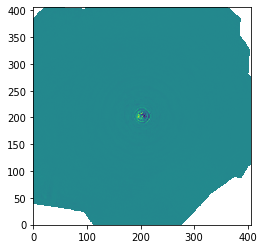

In [15]:
plt.imshow(adi_frame, origin="lower")
plt.show()

In [42]:
# plot means

plt.clf()
plt.plot(np.multiply(rad_stats.r,0.0107), rad_stats.mean, marker="o")
plt.axvline(x=np.multiply(15.5,0.0107), linestyle=":", color="k")
plt.title("Mean values of residuals")
plt.xlabel("Radius (asec)")
plt.ylabel("Mean val")
plt.show()
#plt.savefig("junk.pdf")

In [43]:
# plot stdev

plt.clf()
plt.plot(np.multiply(rad_stats.r,0.0107), rad_stats.std, marker="o")
plt.axvline(x=np.multiply(15.5,0.0107), linestyle=":", color="k")
plt.title("Stdev of residuals")
plt.xlabel("Radius (asec)")
plt.ylabel("Stdev")
plt.show()
#plt.savefig("junk.pdf")

In [45]:
# ampl_host

# plot 5*stdev/ampl_host

plt.clf()
plt.plot(np.multiply(rad_stats.r,0.0107), linear_5sig_contrast, marker="o")
plt.axvline(x=np.multiply(15.5,0.0107), linestyle=":", color="k")
plt.title("Classical contrast curve, annulus width 1 (in counts, linear)")
plt.xlabel("Radius (asec)")
plt.ylabel("5*noise/ampl_host")
plt.show()
#plt.savefig("junk.pdf")

In [56]:
# calculate contrasts

linear_5sig_contrast_width01 = np.divide(5.*rad_stats.std,ampl_host)
# convert contrast to mags
del_mags_contrast_width01 = -2.5*np.log10(linear_5sig_contrast_width01)

linear_5sig_contrast_width10 = np.divide(5.*rad_stats_width10.std,ampl_host)
# convert contrast to mags
del_mags_contrast_width10 = -2.5*np.log10(linear_5sig_contrast_width10)

/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


In [59]:
# write out 5*stdev/ampl_host to csv



array([        inf,  5.24116577,  4.9377372 ,  5.51877131,  4.86915975,
        4.89705129,  5.24624341,  5.05801352,  5.86569157,  5.85788691,
        6.14896585,  5.71869107,  5.87536068,  6.38571141,  6.3870921 ,
        6.86777271,  7.91724989,  8.10220367,  7.96507499,  7.83216778,
        7.99781616,  8.25206721,  8.34896627,  8.43094618,  8.35740781,
        8.50105082,  8.76755752,  8.90686945,  8.92352366,  8.8829825 ,
        8.74361446,  8.6956007 ,  8.66300567,  8.76261667,  8.87174403,
        9.10162356,  9.33643454,  9.54012298,  9.39989813,  9.2376179 ,
        9.26179967,  9.20809627,  9.42316583,  9.49353381,  9.48135043,
        9.43337184,  9.54856596,  9.67466207,  9.54558499,  9.50911524,
        9.60415344,  9.68788464,  9.58979375,  9.61713863,  9.54596741,
        9.71302597,  9.96748714,  9.99371895,  9.92855716,  9.93650526,
        9.92467851,  9.99462277,  9.92466956,  9.84568552,  9.92947772,
        9.83352683,  9.89102152, 10.0025342 , 10.05549108, 10.08

In [52]:
# plot curve: 
# - annulus width 10
# - linear

# plot 5*stdev/ampl_host

plt.clf()
plt.plot(np.multiply(rad_stats_width10.r,0.0107), np.divide(5.*rad_stats_width10.std,ampl_host), marker="o")
plt.axvline(x=np.multiply(15.5,0.0107), linestyle=":", color="k")
plt.title("Classical contrast curve, annulus width 10")
plt.xlabel("Radius (asec)")
plt.ylabel("5*noise/ampl_host")
plt.show()
#plt.savefig("junk.pdf")

In [61]:
# plot curve: 
# - annulus width 10
# - del_mag

# plot 5*stdev/ampl_host

plt.clf()
plt.plot(np.multiply(rad_stats_width10.r,0.0107), del_mags_contrast_width10, marker="o")
plt.axvline(x=np.multiply(15.5,0.0107), linestyle=":", color="k")
plt.title("Classical contrast curve, annulus width 10")
plt.xlabel("Radius (asec)")
plt.ylabel("del_mag")
plt.gca().invert_yaxis()
plt.show()
#plt.savefig("junk.pdf")

In [52]:
# ampl_host

# plot 5*stdev/ampl_host

plt.clf()
plt.plot(np.multiply(rad_stats_width10.r,0.0107), del_mags_contrast, marker="o")
plt.axvline(x=np.multiply(15.5,0.0107), linestyle=":", color="k")
plt.title("Classical contrast curve, annulus width 10")
plt.xlabel("Radius (asec)")
plt.ylabel("5*noise/ampl_host")
plt.show()
#plt.savefig("junk.pdf")

In [ ]:
# write out 5*stdev/ampl_host to csv

